Import all appropriate Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder




## Data Cleaning
Lets first import the data.

In [15]:
df_red_cost = pd.read_csv("Data/Raw/Wine_Datasets/Kaggle/Red.csv")
df_rose_cost = pd.read_csv("Data/Raw/Wine_Datasets/Kaggle/Rose.csv")
df_sparkling_cost = pd.read_csv("Data/Raw/Wine_Datasets/Kaggle/Sparkling.csv")
df_white_cost = pd.read_csv("Data/Raw/Wine_Datasets/Kaggle/White.csv")

# Merge all wine cost datasets with one-hot encoding for wine types
print("=== Merging Wine Cost Datasets ===\n")

# Create copies and add wine type indicators
df_red_cost_copy = df_red_cost.copy()
df_white_cost_copy = df_white_cost.copy()
df_rose_cost_copy = df_rose_cost.copy()
df_sparkling_cost_copy = df_sparkling_cost.copy()

# Add one-hot encoded wine type columns
df_red_cost_copy['is_red_wine'] = 1
df_red_cost_copy['is_white_wine'] = 0
df_red_cost_copy['is_rose_wine'] = 0

df_white_cost_copy['is_red_wine'] = 0
df_white_cost_copy['is_white_wine'] = 1
df_white_cost_copy['is_rose_wine'] = 0

df_rose_cost_copy['is_red_wine'] = 0
df_rose_cost_copy['is_white_wine'] = 0
df_rose_cost_copy['is_rose_wine'] = 1

df_sparkling_cost_copy['is_red_wine'] = 0
df_sparkling_cost_copy['is_white_wine'] = 0
df_sparkling_cost_copy['is_rose_wine'] = 0

# Merge all datasets
df= pd.concat([
    df_red_cost_copy, 
    df_white_cost_copy, 
    df_rose_cost_copy, 
    df_sparkling_cost_copy
], ignore_index=True)

print("Dataset merging complete!")
print(f"Red wine samples: {len(df_red_cost_copy):,}")
print(f"White wine samples: {len(df_white_cost_copy):,}")
print(f"Rose wine samples: {len(df_rose_cost_copy):,}")
print(f"Sparkling wine samples: {len(df_sparkling_cost_copy):,}")
print(f"Total merged samples: {len(df):,}")

print(f"\nMerged dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Verify one-hot encoding
print(f"\nWine type distribution verification:")
print(f"Red wines: {df['is_red_wine'].sum():,}")
print(f"White wines: {df['is_white_wine'].sum():,}")
print(f"Rose wines: {df['is_rose_wine'].sum():,}")

# Check for any missing values in the merged dataset
print(f"\nMissing values in merged dataset:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])
    

                                 Name  Country     Region  \
0                        Pomerol 2011   France    Pomerol   
1                          Lirac 2017   France      Lirac   
2  Erta e China Rosso di Toscana 2015    Italy    Toscana   
3                      Bardolino 2019    Italy  Bardolino   
4      Ried Scheibner Pinot Noir 2016  Austria  Carnuntum   

                  Winery  Rating  Price  Year  
0  Château La Providence     4.2  95.00  2011  
1     Château Mont-Redon     4.3  15.50  2017  
2             Renzo Masi     3.9   7.45  2015  
3             Cavalchina     3.5   8.72  2019  
4            Markowitsch     3.9  29.15  2016  
=== Merging Wine Cost Datasets ===

Dataset merging complete!
Red wine samples: 8,666
White wine samples: 3,764
Rose wine samples: 397
Sparkling wine samples: 1,007
Total merged samples: 13,834

Merged dataset shape: (13834, 10)
Columns: ['Name', 'Country', 'Region', 'Winery', 'Rating', 'Price', 'Year', 'is_red_wine', 'is_white_wine', 'is_rose

In [75]:
# Clean Year column - Replace N.V values and 0 values with median
print("=== Cleaning Year Column - Replacing N.V and 0 values with median ===\n")

if 'Year' in df.columns:
    # Check for N.V values and 0 values before cleaning
    nv_count_before = (df['Year'] == 'N.V.').sum()
    null_count_before = df['Year'].isnull().sum()
    nan_count_before = np.isnan(df['Year']).sum() if df['Year'].dtype == float else 0
    zero_count_before = (df['Year'] == 0).sum() + (df['Year'] == '0').sum()

    print(f"  N.V. values found: {nv_count_before}")
    print(f"  Null values found: {null_count_before}")
    print(f"  NaN values found: {nan_count_before}")
    print(f"  Zero values found: {zero_count_before}")
    
    # First, convert numeric values to get the median (excluding N.V. and 0 values)
    df_temp = df['Year'].copy()
    
    # Replace N.V. variations and 0 values with NaN temporarily
    df_temp = df_temp.replace(['N.V.', 'N.V', 'NV', 'n.v.', 'n.v', 'nv', 0, '0'], np.nan)
    
    # Convert to numeric
    df_temp = pd.to_numeric(df_temp, errors='coerce')
    
    # Calculate median of valid (non-NaN, non-zero) values
    median_year = df_temp.median()
    print(f"  Calculated median year from valid values: {median_year:.0f}")
    
    # Now replace N.V. values and 0 values with median in the original column
    df['Year'] = df['Year'].replace(['N.V.', 'N.V', 'NV', 'n.v.', 'n.v', 'nv', 0, '0'], median_year)

    # Convert Year column to numeric, handling any remaining non-numeric values
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

    # Replace any remaining NaN values (from failed conversions) with median
    df['Year'] = df['Year'].fillna(median_year)

    # Convert to integer
    df['Year'] = df['Year'].astype(int)

    # Check results after cleaning
    median_count_after = (df['Year'] == int(median_year)).sum()

    print(f"  After cleaning - Values replaced with median ({int(median_year)}): {median_count_after}")
    print(f"  Year range: {df['Year'].min()} to {df['Year'].max()}")
    print(f"  Data type: {df['Year'].dtype}")
    print()

=== Cleaning Year Column - Replacing N.V and 0 values with median ===

  N.V. values found: 0
  Null values found: 0
  NaN values found: 0
  Zero values found: 744
  Calculated median year from valid values: 2016
  After cleaning - Values replaced with median (2016): 3038
  Year range: 1961 to 2020
  Data type: int64



In [76]:

def remove_outliers(df, column):
    # Keep only points within IQR range
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return filtered_df 

red_onehot = pd.get_dummies(df, columns=['Country', 'Region'])
red_onehot = remove_outliers(red_onehot, 'Price')

# Print min/max prices after outlier removal: 
print(f"Maximum wine-price after cleaning: {red_onehot['Price'].max()}")
print(f"Minimum wine price after cleaning: {red_onehot['Price'].min()}")

red_onehot.drop(['Name', 'is_red_wine', 'Winery'], axis=1, inplace=True) # drop Name and Winery to avoid overfitting and high-dimensionality after encoding

red_onehot.dropna(inplace=True)

X = red_onehot.drop(["Price"], axis=1)
y = red_onehot["Price"]

print(f"Features shape: {X.shape}, Target shape: {y.shape}")

# Split data into train, validation and test sets 
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

print(f"Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation set: {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test= scaler.transform(X_test)


Maximum wine-price after cleaning: 66.31
Minimum wine price after cleaning: 3.15
Features shape: (12521, 898), Target shape: (12521,)
Training set: 7512 samples (60.0%)
Validation set: 2504 samples (20.0%)
Test set: 2505 samples (20.0%)


## Linear Regression

--- Linear Regression Results ---
Linear Regression MAE: 6.1976
Linear Regression MSE: 69.8726
Linear Regression RMSE: 8.3590
Linear Regression R2: 0.6313


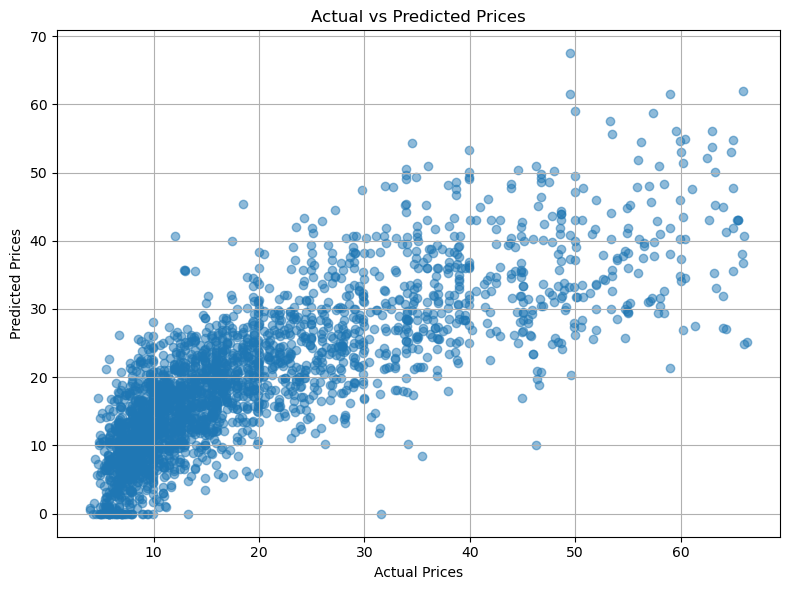

In [77]:
# Identical data splits across model.
# Fit linear regression model
lr_model = LinearRegression() # No hyperparameters to tune
lr_model.fit(X_train, y_train)

# Predict on test set
y_pred_lr = lr_model.predict(X_test)

# Prevent negative price predictions
y_pred_lr = np.maximum(y_pred_lr, 0)

# Evaluate model
mse = mean_squared_error(y_test, y_pred_lr)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_lr)
r2 = r2_score(y_test, y_pred_lr)

print("--- Linear Regression Results ---")
print(f"Linear Regression MAE: {mae:.4f}")
print(f"Linear Regression MSE: {mse:.4f}")
print(f"Linear Regression RMSE: {rmse:.4f}")
print(f"Linear Regression R2: {r2:.4f}")

# Plot actual vs predicted prices
plt.figure(figsize=(8, 6))
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices")
plt.scatter(y_test, y_pred_lr, alpha=0.5)
plt.grid(True)
plt.tight_layout()
plt.show()


## Gradient Boosting


=== Hyperparameter Tuning ===
Training dataset shape: (7512, 898)
Validation dataset shape: (2504, 898)
Test dataset shape: (2505, 898)
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
Best CV score: -7.8634
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
Best CV score: -7.8634

R² across 3 CV folds:
  Fold 1: 0.6555
  Fold 2: 0.6718
  Fold 3: 0.6795
Mean R²: 0.6689 ± 0.0100

MSE across 3 CV folds:
  Fold 1: 62.1978
  Fold 2: 63.7012
  Fold 3: 59.6357
Mean MSE: 61.8449 ± 1.6784

MAE across 3 CV folds:
  Fold 1: 5.4240
  Fold 2: 5.4732
  Fold 3: 5.2839
Mean MAE: 5.3937 ± 0.0802
Validation MSE: 59.5865
Validation RMSE: 7.7192
Validation MAE: 5.3065
Validation R²: 0.6869

R² across 3 CV folds:
  Fold 1: 0.6555
  Fold 2: 0.6718
  Fold 3: 0.6795
Mean R²: 0.6689 ± 0.0100

MSE across 3 CV folds:
  Fold 1: 62.1978
  Fold 2: 63.7012
  Fold 3: 59.6357
Mean MSE: 61.8449 ± 1.6784


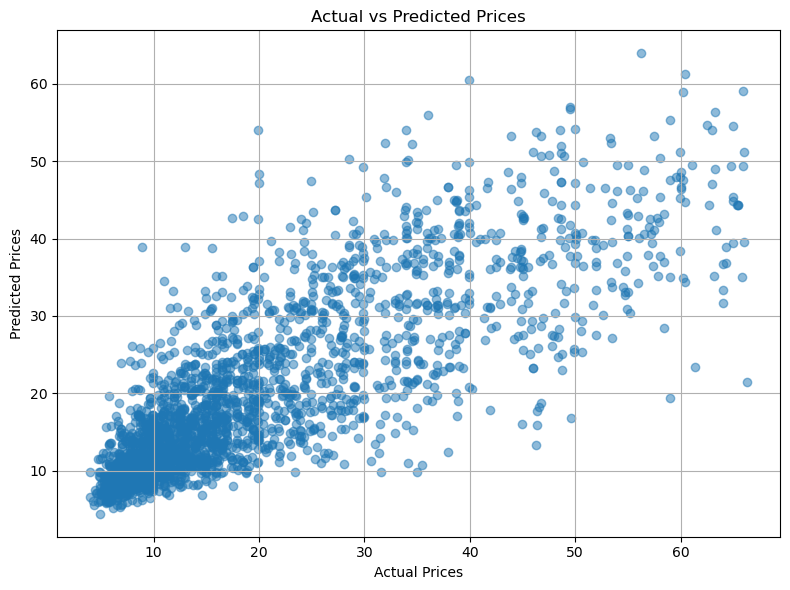

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Gradient Boosting with validation and hyperparameter tuning
print("\n=== Hyperparameter Tuning ===")
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [3, 5], # Ignore subsample and min_samples_split for memory constraints
}

print(f"Training dataset shape: {X_train.shape}")
print(f"Validation dataset shape: {X_val.shape}")
print(f"Test dataset shape: {X_test.shape}")

# Use GridSearchCV for hyperparameter tuning
gb_model_base = GradientBoostingRegressor(random_state=42)

grid_search = GridSearchCV(
    gb_model_base, 
    param_grid, 
    cv=3,  # Use 3-fold CV to save memory
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

# Calculate multiple metrics across cross-validation folds
cv_r2_scores = cross_val_score(
    grid_search.best_estimator_, 
    X_train, 
    y_train, 
    cv=3, 
    scoring='r2',
    n_jobs=-1
)

cv_mse_scores = cross_val_score(
    grid_search.best_estimator_, 
    X_train, 
    y_train, 
    cv=3, 
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

cv_mae_scores = cross_val_score(
    grid_search.best_estimator_, 
    X_train, 
    y_train, 
    cv=3, 
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

print(f"\nR² across 3 CV folds:")
for i, score in enumerate(cv_r2_scores, 1):
    print(f"  Fold {i}: {score:.4f}")
print(f"Mean R²: {cv_r2_scores.mean():.4f} ± {cv_r2_scores.std():.4f}")

print(f"\nMSE across 3 CV folds:")
for i, score in enumerate(-cv_mse_scores, 1):  # Convert back to positive MSE
    print(f"  Fold {i}: {score:.4f}")
print(f"Mean MSE: {(-cv_mse_scores).mean():.4f} ± {(-cv_mse_scores).std():.4f}")

print(f"\nMAE across 3 CV folds:")
for i, score in enumerate(-cv_mae_scores, 1):  # Convert back to positive MAE
    print(f"  Fold {i}: {score:.4f}")
print(f"Mean MAE: {(-cv_mae_scores).mean():.4f} ± {(-cv_mae_scores).std():.4f}")

# Use best model
gb_model = grid_search.best_estimator_

# Validation performance
y_val_pred = gb_model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)
print(f"Validation MSE: {val_mse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Validation MAE: {val_mae:.4f}")
print(f"Validation R²: {val_r2:.4f}")

# Final test performance
y_pred = gb_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)
print(f"Test MSE: {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R²: {test_r2:.4f}")

# Debug: Check predictions
print(f"Predictions range: ${y_pred.min():.2f} to ${y_pred.max():.2f}")
print(f"Actual price range: ${y_test.min():.2f} to ${y_test.max():.2f}")

# Check for negative price predictions
negative_preds = y_pred[y_pred < 0]
if len(negative_preds) > 0:
    print(f"WARNING: Found {len(negative_preds)} negative price predictions!")
    print(f"Negative predictions: {negative_preds}")
else:
    print("All predictions are positive prices")
    
print(f"Gradient Boosting Final R²: {test_r2:.4f}")

print("\n" + "="*60)
print("GRADIENT BOOSTING RESULTS SUMMARY")
print("="*60)
print(f"Best Parameters:")
for param, value in gb_model.get_params().items():
    if param in param_grid.keys():
        print(f"  {param}: {value}")

print(f"\nCross-Validation Performance:")
print(f"  Mean R²: {cv_r2_scores.mean():.4f} ± {cv_r2_scores.std():.4f}")
print(f"  Mean MSE: {(-cv_mse_scores).mean():.4f} ± {(-cv_mse_scores).std():.4f}")
print(f"  Mean MAE: {(-cv_mae_scores).mean():.4f} ± {(-cv_mae_scores).std():.4f}")

print(f"\nValidation Set Performance:")
print(f"  MSE: {val_mse:.4f}")
print(f"  RMSE: {val_rmse:.4f}")
print(f"  MAE: {val_mae:.4f}")
print(f"  R²: {val_r2:.4f}")

print(f"\nTest Set Performance:")
print(f"  MSE: {test_mse:.4f}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  MAE: {test_mae:.4f}")
print(f"  R²: {test_r2:.4f}")

print(f"\nBest model stored in variable 'gb_model'")
print("="*60)

# --- Plot Actual vs Predicted Prices ---
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices")
plt.grid(True)
plt.tight_layout()
plt.show()

## Ridge Regression


=== Ridge Regression Hyperparameter Tuning ===
Training dataset shape: (7512, 898)
Validation dataset shape: (2504, 898)
Test dataset shape: (2505, 898)
Fitting 3 folds for each of 7 candidates, totalling 21 fits
Best parameters: {'alpha': 100.0}
Best CV score: -8.6263
Best parameters: {'alpha': 100.0}
Best CV score: -8.6263

R² across 3 CV folds:
  Fold 1: 0.5793
  Fold 2: 0.6080
  Fold 3: 0.6171
Mean R²: 0.6015 ± 0.0161

MSE across 3 CV folds:
  Fold 1: 75.9627
  Fold 2: 76.0879
  Fold 3: 71.2423
Mean MSE: 74.4310 ± 2.2553

MAE across 3 CV folds:
  Fold 1: 6.2339
  Fold 2: 6.3177
  Fold 3: 6.1341
Mean MAE: 6.2286 ± 0.0750
Validation MSE: 70.7541
Validation RMSE: 8.4115
Validation MAE: 6.2039
Validation R²: 0.6282
Test MSE: 69.8291
Test RMSE: 8.3564
Test MAE: 6.1869
Test R²: 0.6315
Predictions range: $0.00 to $67.01
Actual price range: $3.95 to $66.31
All predictions are positive prices
Ridge Regression Final R²: 0.6315

RIDGE REGRESSION RESULTS SUMMARY
Best Parameters:
  alpha: 100.

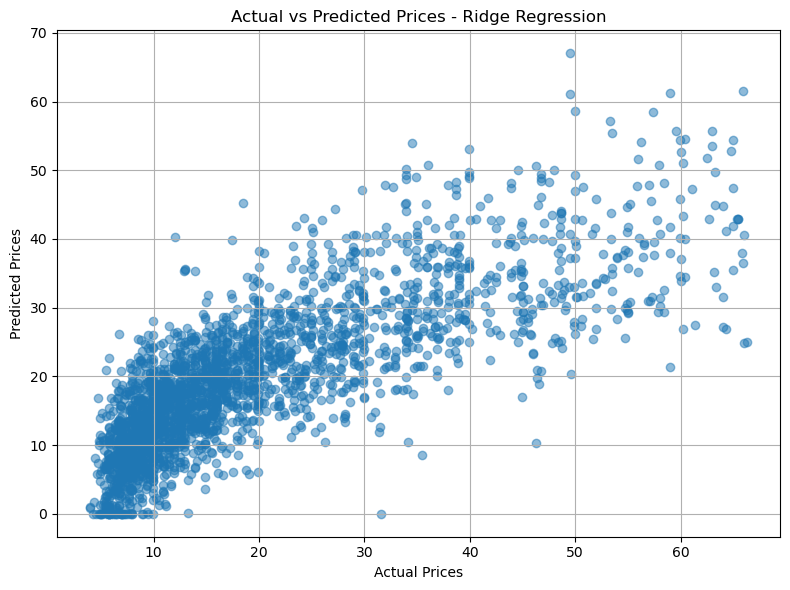

In [78]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Ridge Regression with Grid Search Optimization
print("\n=== Ridge Regression Hyperparameter Tuning ===")
param_grid_ridge = {
    'alpha': [0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
}

print(f"Training dataset shape: {X_train.shape}")
print(f"Validation dataset shape: {X_val.shape}")
print(f"Test dataset shape: {X_test.shape}")

# Use GridSearchCV for hyperparameter tuning
ridge_model_base = Ridge(random_state=42)

grid_search_ridge = GridSearchCV(
    ridge_model_base, 
    param_grid_ridge, 
    cv=3,  # Use 3-fold CV to save memory
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search_ridge.fit(X_train, y_train)

print(f"Best parameters: {grid_search_ridge.best_params_}")
print(f"Best CV score: {grid_search_ridge.best_score_:.4f}")

# Calculate multiple metrics across cross-validation folds
cv_r2_scores = cross_val_score(
    grid_search_ridge.best_estimator_, 
    X_train, 
    y_train, 
    cv=3, 
    scoring='r2',
    n_jobs=-1
)

cv_mse_scores = cross_val_score(
    grid_search_ridge.best_estimator_, 
    X_train, 
    y_train, 
    cv=3, 
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

cv_mae_scores = cross_val_score(
    grid_search_ridge.best_estimator_, 
    X_train, 
    y_train, 
    cv=3, 
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

print(f"\nR² across 3 CV folds:")
for i, score in enumerate(cv_r2_scores, 1):
    print(f"  Fold {i}: {score:.4f}")
print(f"Mean R²: {cv_r2_scores.mean():.4f} ± {cv_r2_scores.std():.4f}")

print(f"\nMSE across 3 CV folds:")
for i, score in enumerate(-cv_mse_scores, 1):  # Convert back to positive MSE
    print(f"  Fold {i}: {score:.4f}")
print(f"Mean MSE: {(-cv_mse_scores).mean():.4f} ± {(-cv_mse_scores).std():.4f}")

print(f"\nMAE across 3 CV folds:")
for i, score in enumerate(-cv_mae_scores, 1):  # Convert back to positive MAE
    print(f"  Fold {i}: {score:.4f}")
print(f"Mean MAE: {(-cv_mae_scores).mean():.4f} ± {(-cv_mae_scores).std():.4f}")

# Use best model
ridge_model = grid_search_ridge.best_estimator_

# Validation performance
y_val_pred = ridge_model.predict(X_val)
y_val_pred = np.maximum(y_val_pred, 0)  # Prevent negative predictions
val_mse = mean_squared_error(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)
print(f"Validation MSE: {val_mse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Validation MAE: {val_mae:.4f}")
print(f"Validation R²: {val_r2:.4f}")

# Final test performance
y_pred_ridge = ridge_model.predict(X_test)
y_pred_ridge = np.maximum(y_pred_ridge, 0)  # Prevent negative predictions
test_mse = mean_squared_error(y_test, y_pred_ridge)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred_ridge)
test_r2 = r2_score(y_test, y_pred_ridge)
print(f"Test MSE: {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R²: {test_r2:.4f}")

# Debug: Check predictions
print(f"Predictions range: ${y_pred_ridge.min():.2f} to ${y_pred_ridge.max():.2f}")
print(f"Actual price range: ${y_test.min():.2f} to ${y_test.max():.2f}")

# Check for negative price predictions
negative_preds = y_pred_ridge[y_pred_ridge < 0]
if len(negative_preds) > 0:
    print(f"WARNING: Found {len(negative_preds)} negative price predictions!")
    print(f"Negative predictions: {negative_preds}")
else:
    print("All predictions are positive prices")
    
print(f"Ridge Regression Final R²: {test_r2:.4f}")

print("\n" + "="*60)
print("RIDGE REGRESSION RESULTS SUMMARY")
print("="*60)
print(f"Best Parameters:")
for param, value in ridge_model.get_params().items():
    if param in param_grid_ridge.keys():
        print(f"  {param}: {value}")

print(f"\nCross-Validation Performance:")
print(f"  Mean R²: {cv_r2_scores.mean():.4f} ± {cv_r2_scores.std():.4f}")
print(f"  Mean MSE: {(-cv_mse_scores).mean():.4f} ± {(-cv_mse_scores).std():.4f}")
print(f"  Mean MAE: {(-cv_mae_scores).mean():.4f} ± {(-cv_mae_scores).std():.4f}")

print(f"\nValidation Set Performance:")
print(f"  MSE: {val_mse:.4f}")
print(f"  RMSE: {val_rmse:.4f}")
print(f"  MAE: {val_mae:.4f}")
print(f"  R²: {val_r2:.4f}")

print(f"\nTest Set Performance:")
print(f"  MSE: {test_mse:.4f}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  MAE: {test_mae:.4f}")
print(f"  R²: {test_r2:.4f}")

print(f"\nBest model stored in variable 'ridge_model'")
print("="*60)

# --- Plot Actual vs Predicted Prices ---
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_ridge, alpha=0.5)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices - Ridge Regression")
plt.grid(True)
plt.tight_layout()
plt.show()

## Lasso Regression


=== Lasso Regression Hyperparameter Tuning ===
Training dataset shape: (7512, 898)
Validation dataset shape: (2504, 898)
Test dataset shape: (2505, 898)
Fitting 3 folds for each of 7 candidates, totalling 21 fits
Best parameters: {'alpha': 0.05}
Best CV score: -8.5764
Best parameters: {'alpha': 0.05}
Best CV score: -8.5764

R² across 3 CV folds:
  Fold 1: 0.5830
  Fold 2: 0.6107
  Fold 3: 0.6245
Mean R²: 0.6060 ± 0.0172

MSE across 3 CV folds:
  Fold 1: 75.2850
  Fold 2: 75.5743
  Fold 3: 69.8775
Mean MSE: 73.5790 ± 2.6200

MAE across 3 CV folds:
  Fold 1: 6.2057
  Fold 2: 6.3058
  Fold 3: 6.0458
Mean MAE: 6.1858 ± 0.1071
Validation MSE: 69.8462
Validation RMSE: 8.3574
Validation MAE: 6.1338
Validation R²: 0.6329
Test MSE: 69.5649
Test RMSE: 8.3406
Test MAE: 6.1779
Test R²: 0.6329
Predictions range: $0.00 to $67.51
Actual price range: $3.95 to $66.31
All predictions are positive prices
Number of selected features: 511 out of 898
Lasso Regression Final R²: 0.6329

LASSO REGRESSION RESU

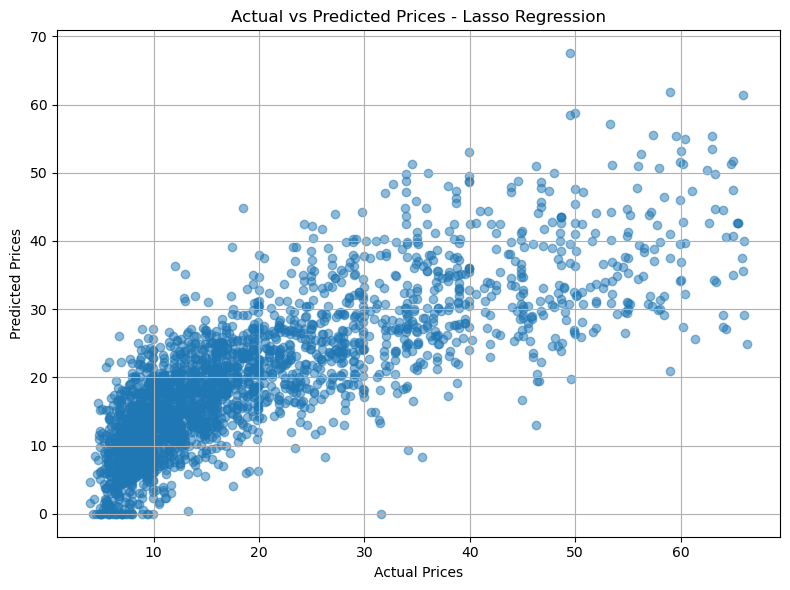

In [79]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Lasso Regression with Grid Search Optimization
print("\n=== Lasso Regression Hyperparameter Tuning ===")
param_grid_lasso = {
    'alpha': [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]
}

print(f"Training dataset shape: {X_train.shape}")
print(f"Validation dataset shape: {X_val.shape}")
print(f"Test dataset shape: {X_test.shape}")

# Use GridSearchCV for hyperparameter tuning
lasso_model_base = Lasso(random_state=42, max_iter=2000)  # Increased max_iter for convergence

grid_search_lasso = GridSearchCV(
    lasso_model_base, 
    param_grid_lasso, 
    cv=3,  # Use 3-fold CV to save memory
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search_lasso.fit(X_train, y_train)

print(f"Best parameters: {grid_search_lasso.best_params_}")
print(f"Best CV score: {grid_search_lasso.best_score_:.4f}")

# Calculate multiple metrics across cross-validation folds
cv_r2_scores = cross_val_score(
    grid_search_lasso.best_estimator_, 
    X_train, 
    y_train, 
    cv=3, 
    scoring='r2',
    n_jobs=-1
)

cv_mse_scores = cross_val_score(
    grid_search_lasso.best_estimator_, 
    X_train, 
    y_train, 
    cv=3, 
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

cv_mae_scores = cross_val_score(
    grid_search_lasso.best_estimator_, 
    X_train, 
    y_train, 
    cv=3, 
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

print(f"\nR² across 3 CV folds:")
for i, score in enumerate(cv_r2_scores, 1):
    print(f"  Fold {i}: {score:.4f}")
print(f"Mean R²: {cv_r2_scores.mean():.4f} ± {cv_r2_scores.std():.4f}")

print(f"\nMSE across 3 CV folds:")
for i, score in enumerate(-cv_mse_scores, 1):  # Convert back to positive MSE
    print(f"  Fold {i}: {score:.4f}")
print(f"Mean MSE: {(-cv_mse_scores).mean():.4f} ± {(-cv_mse_scores).std():.4f}")

print(f"\nMAE across 3 CV folds:")
for i, score in enumerate(-cv_mae_scores, 1):  # Convert back to positive MAE
    print(f"  Fold {i}: {score:.4f}")
print(f"Mean MAE: {(-cv_mae_scores).mean():.4f} ± {(-cv_mae_scores).std():.4f}")

# Use best model
lasso_model = grid_search_lasso.best_estimator_

# Validation performance
y_val_pred = lasso_model.predict(X_val)
y_val_pred = np.maximum(y_val_pred, 0)  # Prevent negative predictions
val_mse = mean_squared_error(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)
print(f"Validation MSE: {val_mse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Validation MAE: {val_mae:.4f}")
print(f"Validation R²: {val_r2:.4f}")

# Final test performance
y_pred_lasso = lasso_model.predict(X_test)
y_pred_lasso = np.maximum(y_pred_lasso, 0)  # Prevent negative predictions
test_mse = mean_squared_error(y_test, y_pred_lasso)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred_lasso)
test_r2 = r2_score(y_test, y_pred_lasso)
print(f"Test MSE: {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R²: {test_r2:.4f}")

# Debug: Check predictions
print(f"Predictions range: ${y_pred_lasso.min():.2f} to ${y_pred_lasso.max():.2f}")
print(f"Actual price range: ${y_test.min():.2f} to ${y_test.max():.2f}")

# Check for negative price predictions
negative_preds = y_pred_lasso[y_pred_lasso < 0]
if len(negative_preds) > 0:
    print(f"WARNING: Found {len(negative_preds)} negative price predictions!")
    print(f"Negative predictions: {negative_preds}")
else:
    print("All predictions are positive prices")

# Check for feature selection (Lasso specific)
n_selected_features = np.sum(np.abs(lasso_model.coef_) > 1e-6)
print(f"Number of selected features: {n_selected_features} out of {len(lasso_model.coef_)}")
    
print(f"Lasso Regression Final R²: {test_r2:.4f}")

print("\n" + "="*60)
print("LASSO REGRESSION RESULTS SUMMARY")
print("="*60)
print(f"Best Parameters:")
for param, value in lasso_model.get_params().items():
    if param in param_grid_lasso.keys():
        print(f"  {param}: {value}")

print(f"\nFeature Selection:")
print(f"  Selected features: {n_selected_features} out of {len(lasso_model.coef_)}")
print(f"  Feature selection ratio: {n_selected_features/len(lasso_model.coef_)*100:.1f}%")

print(f"\nCross-Validation Performance:")
print(f"  Mean R²: {cv_r2_scores.mean():.4f} ± {cv_r2_scores.std():.4f}")
print(f"  Mean MSE: {(-cv_mse_scores).mean():.4f} ± {(-cv_mse_scores).std():.4f}")
print(f"  Mean MAE: {(-cv_mae_scores).mean():.4f} ± {(-cv_mae_scores).std():.4f}")

print(f"\nValidation Set Performance:")
print(f"  MSE: {val_mse:.4f}")
print(f"  RMSE: {val_rmse:.4f}")
print(f"  MAE: {val_mae:.4f}")
print(f"  R²: {val_r2:.4f}")

print(f"\nTest Set Performance:")
print(f"  MSE: {test_mse:.4f}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  MAE: {test_mae:.4f}")
print(f"  R²: {test_r2:.4f}")

print(f"\nBest model stored in variable 'lasso_model'")
print("="*60)

# --- Plot Actual vs Predicted Prices ---
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lasso, alpha=0.5)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices - Lasso Regression")
plt.grid(True)
plt.tight_layout()
plt.show()

## Random Forest


=== Random Forest Hyperparameter Tuning ===
Training dataset shape: (7512, 898)
Validation dataset shape: (2504, 898)
Test dataset shape: (2505, 898)
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Best CV score: -8.2787

R² across 3 CV folds:
  Fold 1: 0.6165
  Fold 2: 0.6371
  Fold 3: 0.6454
Mean R²: 0.6330 ± 0.0121

MSE across 3 CV folds:
  Fold 1: 69.2378
  Fold 2: 70.4328
  Fold 3: 65.9813
Mean MSE: 68.5506 ± 1.8812

MAE across 3 CV folds:
  Fold 1: 5.5484
  Fold 2: 5.6967
  Fold 3: 5.5199
Mean MAE: 5.5884 ± 0.0775
Validation MSE: 70.4108
Validation RMSE: 8.3911
Validation MAE: 5.6739
Validation R²: 0.6300
Test MSE: 71.3707
Test RMSE: 8.4481
Test MAE: 5.7229
Test R²: 0.6234
Predictions range: $5.06 to $60.90
Actual price range: $3.95 to $66.31
All predictions are positive prices

Top 10 Most Important Features:
  1. Feature 0: 0.4780
  2. Feature 1: 0.2039
  3. Fea

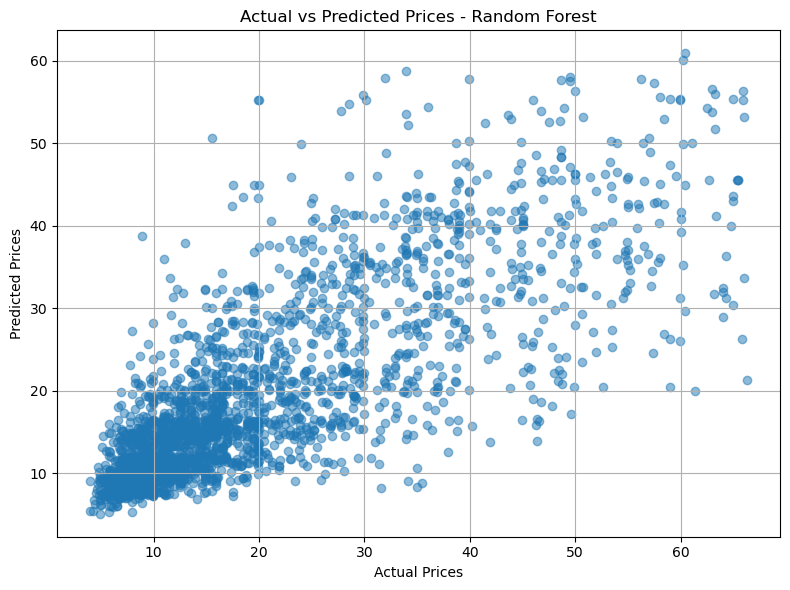

In [62]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Random Forest with Grid Search Optimization
print("\n=== Random Forest Hyperparameter Tuning ===")
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

print(f"Training dataset shape: {X_train.shape}")
print(f"Validation dataset shape: {X_val.shape}")
print(f"Test dataset shape: {X_test.shape}")

# Use GridSearchCV for hyperparameter tuning
rf_model_base = RandomForestRegressor(random_state=42)

grid_search_rf = GridSearchCV(
    rf_model_base, 
    param_grid_rf, 
    cv=3,  # Use 3-fold CV to save memory
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search_rf.fit(X_train, y_train)

print(f"Best parameters: {grid_search_rf.best_params_}")
print(f"Best CV score: {grid_search_rf.best_score_:.4f}")

# Calculate multiple metrics across cross-validation folds
cv_r2_scores = cross_val_score(
    grid_search_rf.best_estimator_, 
    X_train, 
    y_train, 
    cv=3, 
    scoring='r2',
    n_jobs=-1
)

cv_mse_scores = cross_val_score(
    grid_search_rf.best_estimator_, 
    X_train, 
    y_train, 
    cv=3, 
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

cv_mae_scores = cross_val_score(
    grid_search_rf.best_estimator_, 
    X_train, 
    y_train, 
    cv=3, 
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

print(f"\nR² across 3 CV folds:")
for i, score in enumerate(cv_r2_scores, 1):
    print(f"  Fold {i}: {score:.4f}")
print(f"Mean R²: {cv_r2_scores.mean():.4f} ± {cv_r2_scores.std():.4f}")

print(f"\nMSE across 3 CV folds:")
for i, score in enumerate(-cv_mse_scores, 1):  # Convert back to positive MSE
    print(f"  Fold {i}: {score:.4f}")
print(f"Mean MSE: {(-cv_mse_scores).mean():.4f} ± {(-cv_mse_scores).std():.4f}")

print(f"\nMAE across 3 CV folds:")
for i, score in enumerate(-cv_mae_scores, 1):  # Convert back to positive MAE
    print(f"  Fold {i}: {score:.4f}")
print(f"Mean MAE: {(-cv_mae_scores).mean():.4f} ± {(-cv_mae_scores).std():.4f}")

# Use best model
rf_model = grid_search_rf.best_estimator_

# Validation performance
y_val_pred = rf_model.predict(X_val)
y_val_pred = np.maximum(y_val_pred, 0)  # Prevent negative predictions
val_mse = mean_squared_error(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)
print(f"Validation MSE: {val_mse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Validation MAE: {val_mae:.4f}")
print(f"Validation R²: {val_r2:.4f}")

# Final test performance
y_pred_rf = rf_model.predict(X_test)
y_pred_rf = np.maximum(y_pred_rf, 0)  # Prevent negative predictions
test_mse = mean_squared_error(y_test, y_pred_rf)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred_rf)
test_r2 = r2_score(y_test, y_pred_rf)
print(f"Test MSE: {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R²: {test_r2:.4f}")

# Debug: Check predictions
print(f"Predictions range: ${y_pred_rf.min():.2f} to ${y_pred_rf.max():.2f}")
print(f"Actual price range: ${y_test.min():.2f} to ${y_test.max():.2f}")

# Check for negative price predictions
negative_preds = y_pred_rf[y_pred_rf < 0]
if len(negative_preds) > 0:
    print(f"WARNING: Found {len(negative_preds)} negative price predictions!")
    print(f"Negative predictions: {negative_preds}")
else:
    print("All predictions are positive prices")

# Feature importance analysis (Random Forest specific)
feature_names = [f"Feature_{i}" for i in range(len(rf_model.feature_importances_))]
top_features_idx = np.argsort(rf_model.feature_importances_)[-10:]  # Top 10 features
print(f"\nTop 10 Most Important Features:")
for i, idx in enumerate(reversed(top_features_idx)):
    print(f"  {i+1}. Feature {idx}: {rf_model.feature_importances_[idx]:.4f}")
    
print(f"Random Forest Final R²: {test_r2:.4f}")

print("\n" + "="*60)
print("RANDOM FOREST RESULTS SUMMARY")
print("="*60)
print(f"Best Parameters:")
for param, value in rf_model.get_params().items():
    if param in param_grid_rf.keys():
        print(f"  {param}: {value}")

print(f"\nFeature Importance Analysis:")
print(f"  Total features: {len(rf_model.feature_importances_)}")
print(f"  Most important feature importance: {rf_model.feature_importances_.max():.4f}")
print(f"  Average feature importance: {rf_model.feature_importances_.mean():.4f}")

print(f"\nCross-Validation Performance:")
print(f"  Mean R²: {cv_r2_scores.mean():.4f} ± {cv_r2_scores.std():.4f}")
print(f"  Mean MSE: {(-cv_mse_scores).mean():.4f} ± {(-cv_mse_scores).std():.4f}")
print(f"  Mean MAE: {(-cv_mae_scores).mean():.4f} ± {(-cv_mae_scores).std():.4f}")

print(f"\nValidation Set Performance:")
print(f"  MSE: {val_mse:.4f}")
print(f"  RMSE: {val_rmse:.4f}")
print(f"  MAE: {val_mae:.4f}")
print(f"  R²: {val_r2:.4f}")

print(f"\nTest Set Performance:")
print(f"  MSE: {test_mse:.4f}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  MAE: {test_mae:.4f}")
print(f"  R²: {test_r2:.4f}")

print(f"\nBest model stored in variable 'rf_model'")
print("="*60)

# --- Plot Actual vs Predicted Prices ---
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices - Random Forest")
plt.grid(True)
plt.tight_layout()
plt.show()

## Feature Importance Analysis
This section has been constructed with the assistance of Gen-AI.

=== SHAP Feature Analysis for Gradient Boosting Regression ===
Total features to be analyzed: 898
Using 100 training samples and 50 test samples for SHAP analysis
Creating SHAP explainer...
Calculating SHAP values...
SHAP values shape: (50, 898)

=== Identifying Top Features ===
Top 10 most important features:
 1. Rating                         | Importance: 5.7461
 2. Year                           | Importance: 3.6292
 3. Country_France                 | Importance: 1.8433
 4. Country_Spain                  | Importance: 0.3383
 5. is_white_wine                  | Importance: 0.2980
 6. Country_Italy                  | Importance: 0.2183
 7. Country_United States          | Importance: 0.1627
 8. Region_Champagne               | Importance: 0.1621
 9. Country_Portugal               | Importance: 0.1382
10. Region_Saint-Estèphe           | Importance: 0.1187

Found 'Year' feature at position 2 in top 10 features

=== SHAP Visualizations (Top 10 Features Only) ===


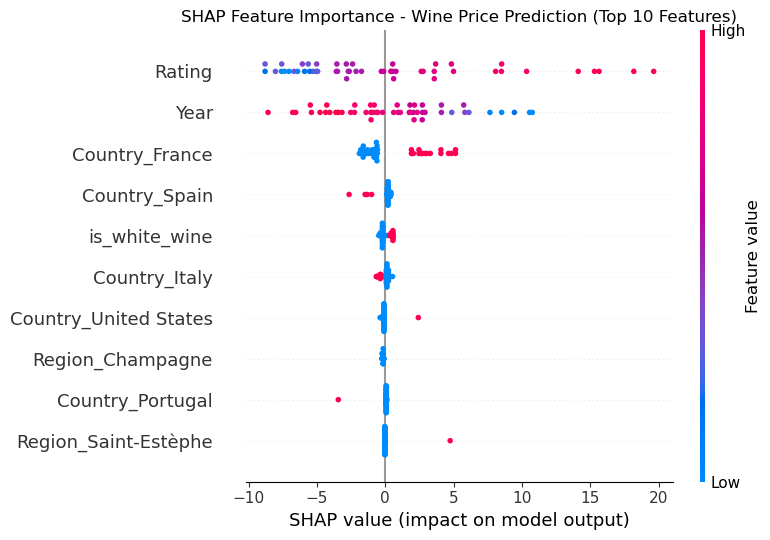

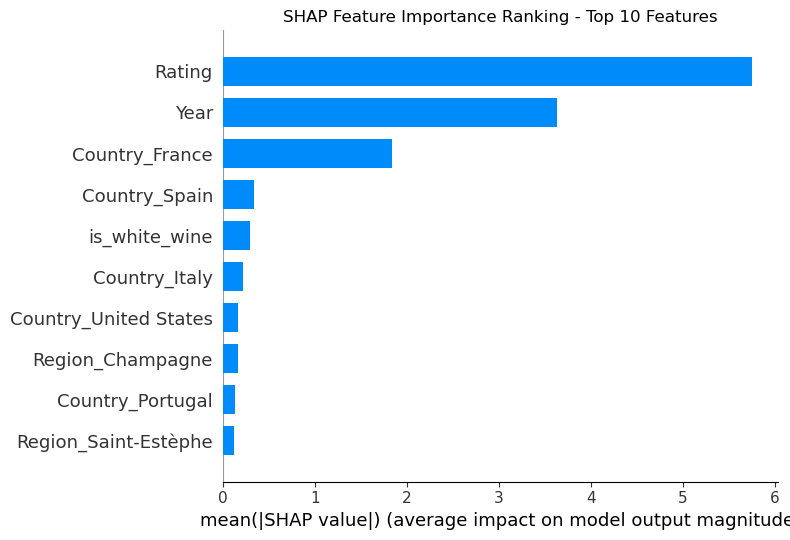


=== Individual Prediction Analysis (Top 10 Features) ===
Sample prediction analysis:
Actual price: $17.79
Predicted price: $25.50
Prediction error: $7.71
Wine year for this prediction: 4033 (centered value: +2017)


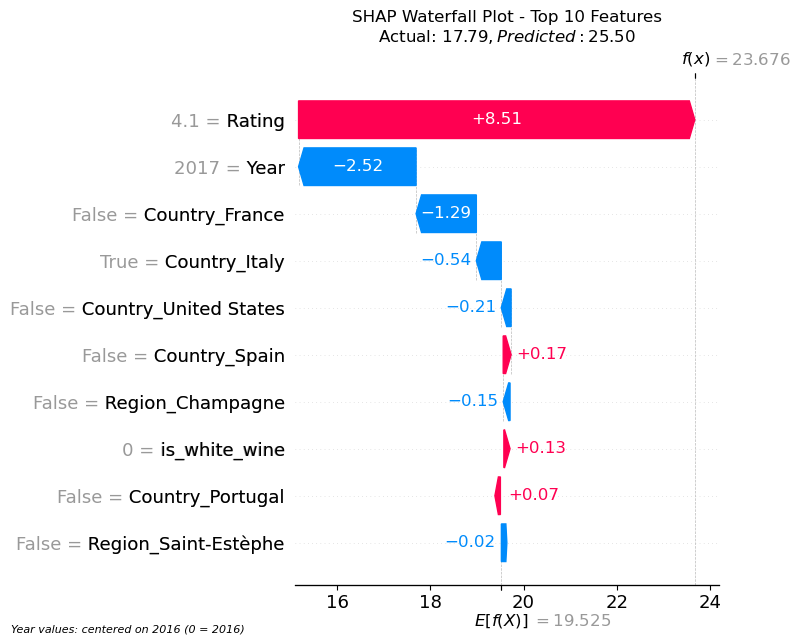


=== Top 10 Features Analysis ===
Top 10 most important features for wine price prediction:
 1. Rating                         | Importance: 5.7461 | Avg Impact: $+0.15
 2. Year                           | Importance: 3.6292 | Avg Impact: $+0.63
 3. Country_France                 | Importance: 1.8433 | Avg Impact: $+0.48
 4. Country_Spain                  | Importance: 0.3383 | Avg Impact: $+0.08
 5. is_white_wine                  | Importance: 0.2980 | Avg Impact: $-0.01
 6. Country_Italy                  | Importance: 0.2183 | Avg Impact: $+0.00
 7. Country_United States          | Importance: 0.1627 | Avg Impact: $-0.07
 8. Region_Champagne               | Importance: 0.1621 | Avg Impact: $-0.16
 9. Country_Portugal               | Importance: 0.1382 | Avg Impact: $+0.00
10. Region_Saint-Estèphe           | Importance: 0.1187 | Avg Impact: $+0.07

=== Feature Impact Distribution ===
Rating:
  Mean impact: $+0.15
  Max positive impact: $+19.64
  Max negative impact: $-8.79
  Standard

In [82]:
!pip install shap 
import shap

print("=== SHAP Feature Analysis for Gradient Boosting Regression ===")

# For regression models, we need to use the original unscaled data
# Get the original feature names before scaling
original_X = red_onehot.drop(["Price"], axis=1)
feature_names = original_X.columns.tolist()
print(f"Total features to be analyzed: {len(feature_names)}")

# Get the original train/test splits (unscaled) for SHAP analysis
X_temp_orig, X_test_orig, y_temp_orig, y_test_orig = train_test_split(original_X, y, test_size=0.2, random_state=42)
X_train_orig, X_val_orig, y_train_orig, y_val_orig = train_test_split(X_temp_orig, y_temp_orig, test_size=0.25, random_state=42)

# Use smaller samples for computational efficiency
X_train_sample = X_train_orig.sample(n=min(100, len(X_train_orig)), random_state=42)
X_test_sample = X_val_orig.sample(n=min(50, len(X_val_orig)), random_state=42)

print(f"Using {len(X_train_sample)} training samples and {len(X_test_sample)} test samples for SHAP analysis")

# Create SHAP explainer for the gradient boosting model
# Note: gb_model was trained on scaled data, but SHAP works better with original scale for interpretation
print("Creating SHAP explainer...")
explainer = shap.TreeExplainer(gb_model)

# We need to scale the sample data since the model expects scaled input
scaler_for_shap = StandardScaler()
X_train_sample_scaled = scaler_for_shap.fit_transform(X_train_sample)
X_test_sample_scaled = scaler_for_shap.transform(X_test_sample)

# Calculate SHAP values
print("Calculating SHAP values...")
shap_values = explainer.shap_values(X_test_sample_scaled)

print(f"SHAP values shape: {shap_values.shape}")

# Identify top 10 most important features
print("\n=== Identifying Top Features ===")
feature_importance = np.abs(shap_values).mean(axis=0)
top_features_idx = np.argsort(feature_importance)[-10:][::-1]  # Top 10 features, sorted by importance

print("Top 10 most important features:")
for i, idx in enumerate(top_features_idx):
    feature_name = feature_names[idx]
    importance = feature_importance[idx]
    print(f"{i+1:2d}. {feature_name:<30} | Importance: {importance:.4f}")

# Filter data to only top 10 features for visualization
X_test_sample_top10 = X_test_sample.iloc[:, top_features_idx].copy()
shap_values_top10 = shap_values[:, top_features_idx]
feature_names_top10 = [feature_names[idx] for idx in top_features_idx]

# Check if Year is in top 10 features
year_idx_in_top10 = None
for i, feature_name in enumerate(feature_names_top10):
    if feature_name == 'Year':
        year_idx_in_top10 = i
        print(f"\nFound 'Year' feature at position {i+1} in top 10 features")
        break

if year_idx_in_top10 is None:
    print("\nNote: 'Year' feature is not in the top 10 most important features")

# Create SHAP plots
print("\n=== SHAP Visualizations (Top 10 Features Only) ===")

# 1. Summary plot (beeswarm) - shows feature importance and impact direction for top 10 features
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_top10, X_test_sample_top10, feature_names=feature_names_top10, show=False)
plt.title("SHAP Feature Importance - Wine Price Prediction (Top 10 Features)")
plt.tight_layout()
plt.show()

# 2. Feature importance bar plot - top 10 features only
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_top10, X_test_sample_top10, feature_names=feature_names_top10, plot_type="bar", show=False)
plt.title("SHAP Feature Importance Ranking - Top 10 Features")
plt.tight_layout()
plt.show()

# 3. Waterfall plot for a single prediction (showing top 10 features)
print(f"\n=== Individual Prediction Analysis (Top 10 Features) ===")
sample_idx = 0
actual_price = y_val_orig.iloc[sample_idx]
predicted_price = gb_model.predict(X_test_sample_scaled[sample_idx:sample_idx+1])[0]

print(f"Sample prediction analysis:")
print(f"Actual price: ${actual_price:.2f}")
print(f"Predicted price: ${predicted_price:.2f}")
print(f"Prediction error: ${abs(actual_price - predicted_price):.2f}")

# Show the year value for this specific prediction if Year is in top 10
if year_idx_in_top10 is not None:
    centered_year_value = X_test_sample_top10.iloc[sample_idx, year_idx_in_top10]
    actual_year = centered_year_value + median_year
    print(f"Wine year for this prediction: {actual_year:.0f} (centered value: {centered_year_value:+.0f})")

plt.figure(figsize=(12, 6))
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_top10[sample_idx], 
        base_values=explainer.expected_value, 
        data=X_test_sample_top10.iloc[sample_idx],
        feature_names=feature_names_top10
    ),
    show=False,
    max_display=10
)
plt.title(f"SHAP Waterfall Plot - Top 10 Features\nActual: ${actual_price:.2f}, Predicted: ${predicted_price:.2f}")
if year_idx_in_top10 is not None:
    plt.figtext(0.02, 0.02, f"Year values: centered on {median_year} (0 = {median_year})", fontsize=8, style='italic')
plt.tight_layout()
plt.show()

# 4. Top feature analysis with monetary impact
print(f"\n=== Top 10 Features Analysis ===")
print("Top 10 most important features for wine price prediction:")
for i, idx in enumerate(top_features_idx):
    feature_name = feature_names[idx]
    importance = feature_importance[idx]
    avg_impact = shap_values[:, idx].mean()
    print(f"{i+1:2d}. {feature_name:<30} | Importance: {importance:.4f} | Avg Impact: ${avg_impact:+.2f}")

# 5. Detailed feature impact analysis
print(f"\n=== Feature Impact Distribution ===")
for i, idx in enumerate(top_features_idx[:5]):  # Show detailed stats for top 5
    feature_name = feature_names[idx]
    feature_shap = shap_values[:, idx]
    print(f"{feature_name}:")
    print(f"  Mean impact: ${feature_shap.mean():+.2f}")
    print(f"  Max positive impact: ${feature_shap.max():+.2f}")
    print(f"  Max negative impact: ${feature_shap.min():+.2f}")
    print(f"  Standard deviation: ${feature_shap.std():.2f}")
    
    # Special analysis for Year if it's in top 5
    if feature_name == 'Year':
        print(f"  Year interpretation:")
        print(f"    Positive SHAP values = newer vintages increase price")
        print(f"    Negative SHAP values = older vintages increase price")
        print(f"    Values around 0 = years near {median_year} (median) have neutral effect")
    print()

# 6. Year-specific analysis if Year is in top features
if year_idx_in_top10 is not None:
    print(f"\n=== Year Feature Analysis ===")
    year_feature_idx = top_features_idx[year_idx_in_top10]
    year_shap_values = shap_values[:, year_feature_idx]
    year_actual_values = X_test_sample.iloc[:, year_feature_idx]
    
    print(f"Year analysis (based on {len(year_shap_values)} samples):")
    
    # Analyze correlation between year and SHAP impact
    recent_wines = year_actual_values >= median_year
    older_wines = year_actual_values < median_year
    
    recent_impact = year_shap_values[recent_wines].mean()
    older_impact = year_shap_values[older_wines].mean()
    
    print(f"Recent wines ({median_year}+): Average impact = ${recent_impact:+.2f}")
    print(f"Older wines (<{median_year}): Average impact = ${older_impact:+.2f}")
    
    if recent_impact > older_impact:
        print(f"→ Recent vintages tend to increase wine prices more than older ones")
    else:
        print(f"→ Older vintages tend to increase wine prices more than recent ones")

print("\n" + "="*60)
print("SHAP ANALYSIS SUMMARY")
print("="*60)
print(f"Model analyzed: Gradient Boosting Regressor")
print(f"Total features available: {len(feature_names)}")
print(f"Features displayed: 10 (most important)")
print(f"Samples analyzed: {len(X_test_sample)}")
if year_idx_in_top10 is not None:
    print(f"Year data: Centered around {median_year} for better visualization")
print(f"\nTop 3 most important features:")
for i, idx in enumerate(top_features_idx[:3]):
    print(f"  {i+1}. {feature_names[idx]}")
print("="*60)